In [1]:
import os 
from config import EXPORT_DATA_PATH, SAMPLING_RATE,DATA_SENTINEL,RESULTS_PATH
import json
import librosa 
import numpy as np
import soundfile as sf
import random
import seaborn as sns
from collections import Counter
from glob import glob
from data.dataset import AugSpectrogramDataset,Augmentation
from IPython.display import Audio
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import librosa.display

from config import SAMPLING_RATE
import torch

# Apply Seaborn default theme
sns.set_theme()  # <- this uses Seaborn's default style and palette


In [2]:
augment = Augmentation()
# DATA_SENTINEL = "macaque"

if DATA_SENTINEL == "macaque":
    duration = 1.0
else:
    duration = 2.0

EXPORT_DATA_PATH = '/net/projects/scratch/summer/valid_until_31_January_2026/ybrima/Datasets/new_ph_clips_exported'
# Load the dataset
train_dataset = AugSpectrogramDataset(f"{EXPORT_DATA_PATH}/train", duration=duration, target_sample_rate=SAMPLING_RATE,transform=augment)
val_dataset = AugSpectrogramDataset(f"{EXPORT_DATA_PATH}/val", duration=duration, target_sample_rate=SAMPLING_RATE)

test_dataset = AugSpectrogramDataset(f"{EXPORT_DATA_PATH}/test", duration=duration, target_sample_rate=SAMPLING_RATE)



train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Inspect one batch
batch = next(iter(test_loader))
print(batch[0]['data'].shape)  # [batch, n_mels, time]
print(batch[1])  # label indices
# print(batch[2])  # label names


torch.Size([32, 1, 257, 345])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 2])


In [3]:
import torch
from collections import Counter

# Extract all labels from the test dataset
all_labels = []
for _, labels in test_loader:
    all_labels.extend(labels.numpy())  # convert to numpy if needed

# Count occurrences of each class
label_counts = Counter(all_labels)
total_samples = len(all_labels)

# Compute class probabilities
class_probs = [count / total_samples for count in label_counts.values()]

# Compute chance level
chance_level = sum(p**2 for p in class_probs)
print(f"Chance level (expected accuracy from random guessing): {chance_level:.4f} ({chance_level*100:.2f}%)")


Chance level (expected accuracy from random guessing): 0.1133 (11.33%)


In [4]:
import librosa
base_path = EXPORT_DATA_PATH

splits = ['train', 'val', 'test']
split_durations = {}

for split in splits:
    split_path = os.path.join(base_path, split)
    durations = []
    
    if not os.path.exists(split_path):
        continue
    
    for cls in os.listdir(split_path):
        class_dir = os.path.join(split_path, cls)
        if os.path.isdir(class_dir):
            for f in os.listdir(class_dir):
                file_path = os.path.join(class_dir, f)
                if os.path.isfile(file_path):
                    # Load audio header only to get duration
                    y, sr = librosa.load(file_path, sr=None)  # preserve original sample rate
                    durations.append(len(y)/sr)  # duration in seconds
    
    durations = np.array(durations)
    split_durations[split] = durations
    print(f"{split}: mean duration = {durations.mean():.3f}s, std = {durations.std():.3f}s, n_files = {len(durations)}")

# Optionally compute overall stats across all splits
all_durations = np.concatenate(list(split_durations.values()))
print(f"Overall: mean duration = {all_durations.mean():.3f}s, std = {all_durations.std():.3f}s, max = {all_durations.max():.3f}s, min = {all_durations.min():.3f}s, n_files = {len(all_durations)}")


train: mean duration = 5.840s, std = 3.068s, n_files = 414
val: mean duration = 6.597s, std = 3.718s, n_files = 48
test: mean duration = 5.536s, std = 2.785s, n_files = 59
Overall: mean duration = 5.875s, std = 3.113s, max = 21.074s, min = 0.882s, n_files = 521


In [5]:
import os
import numpy as np
import librosa

base_path = EXPORT_DATA_PATH

splits = ['train', 'val', 'test']
split_durations = {}
class_level_stats = {}          # per split, per class
overall_class_durations = {}    # aggregated across splits

for split in splits:
    split_path = os.path.join(base_path, split)
    durations = []
    class_level_stats[split] = {}

    if not os.path.exists(split_path):
        continue
    
    print(f"\n===== {split.upper()} SPLIT =====")
    for cls in sorted(os.listdir(split_path)):
        class_dir = os.path.join(split_path, cls)
        if not os.path.isdir(class_dir):
            continue
        
        class_durs = []

        for f in os.listdir(class_dir):
            file_path = os.path.join(class_dir, f)
            if os.path.isfile(file_path):
                y, sr = librosa.load(file_path, sr=None)  # preserve original sr
                d = len(y) / sr
                class_durs.append(d)
                durations.append(d)

                # accumulate for overall class stats
                if cls not in overall_class_durations:
                    overall_class_durations[cls] = []
                overall_class_durations[cls].append(d)

        class_durs = np.array(class_durs)

        if len(class_durs) > 0:
            class_level_stats[split][cls] = class_durs
            print(f"Class {cls}: mean={class_durs.mean():.3f}s, "
                  f"std={class_durs.std():.3f}s, min={class_durs.min():.3f}s, "
                  f"max={class_durs.max():.3f}s, n={len(class_durs)}")
    
    durations = np.array(durations)
    split_durations[split] = durations

    print(f"\n{split} (overall): mean={durations.mean():.3f}s, "
          f"std={durations.std():.3f}s, min={durations.min():.3f}s, "
          f"max={durations.max():.3f}s, n={len(durations)}")


# ===== Overall Stats Across All Splits =====
print("\n==============================")
print("OVERALL ACROSS ALL SPLITS")
print("==============================")

# overall durations (all examples)
all_durations = np.concatenate(list(split_durations.values()))
print(f"Global: mean={all_durations.mean():.3f}s, std={all_durations.std():.3f}s, "
      f"min={all_durations.min():.3f}s, max={all_durations.max():.3f}s, "
      f"n_files={len(all_durations)}")

# overall class-level stats (aggregated over all splits)
print("\nPer-Class Overall Stats (train + val + test):")
for cls in sorted(overall_class_durations.keys()):
    durs = np.array(overall_class_durations[cls])
    print(f"Class {cls}: mean={durs.mean():.3f}s, std={durs.std():.3f}s, "
          f"min={durs.min():.3f}s, max={durs.max():.3f}s, n={len(durs)}")



===== TRAIN SPLIT =====
Class ARN: mean=7.157s, std=4.176s, min=1.903s, max=20.311s, n=35
Class CHE: mean=4.616s, std=2.827s, min=1.471s, max=13.601s, n=30
Class CHI: mean=7.224s, std=3.700s, min=1.465s, max=17.900s, n=40
Class FRE: mean=4.398s, std=2.087s, min=1.559s, max=12.204s, n=42
Class GUM: mean=5.249s, std=2.715s, min=2.335s, max=10.234s, n=12
Class LIT: mean=5.328s, std=2.346s, min=0.985s, max=11.398s, n=52
Class LOU: mean=6.081s, std=3.070s, min=2.005s, max=13.347s, n=39
Class NGO: mean=6.053s, std=2.709s, min=0.882s, max=11.533s, n=28
Class ORI: mean=5.908s, std=2.767s, min=1.140s, max=11.713s, n=16
Class PAN: mean=6.413s, std=2.980s, min=1.677s, max=14.308s, n=80
Class THE: mean=5.018s, std=2.183s, min=1.053s, max=10.986s, n=40

train (overall): mean=5.840s, std=3.068s, min=0.882s, max=20.311s, n=414

===== VAL SPLIT =====
Class ARN: mean=9.970s, std=2.476s, min=7.373s, max=12.688s, n=4
Class CHE: mean=3.520s, std=1.849s, min=1.947s, max=6.115s, n=3
Class CHI: mean=8.842s,

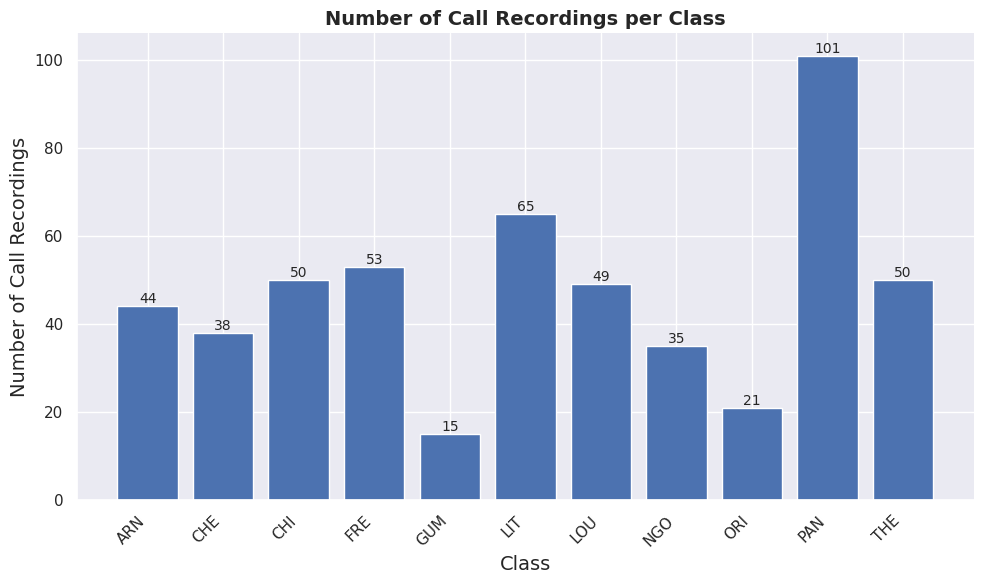

In [6]:


# Apply Seaborn default theme
sns.set_theme()  # <- this uses Seaborn's default style and palette

# Paths
splits = ['train', 'val', 'test']
base_path = EXPORT_DATA_PATH

# Count files per class across all splits
class_counts = Counter()

for split in splits:
    split_path = os.path.join(base_path, split)
    if not os.path.exists(split_path):
        continue
    for cls in os.listdir(split_path):
        class_dir = os.path.join(split_path, cls)
        if os.path.isdir(class_dir):
            num_files = len([
                f for f in os.listdir(class_dir)
                if os.path.isfile(os.path.join(class_dir, f))
            ])
            class_counts[cls] += num_files

# Sort classes alphabetically
classes = sorted(class_counts.keys())
counts = [class_counts[c] for c in classes]

# Plot
plt.figure(figsize=(10, 6))
bars = plt.bar(classes, counts, color=sns.color_palette()[0])

plt.title("Number of Call Recordings per Class", fontsize=14, weight='bold')
plt.xlabel("Class", fontsize=14)
plt.ylabel("Number of Call Recordings", fontsize=14)
plt.xticks(rotation=45, ha='right')

# Annotate bar values
for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), str(count),
             ha='center', va='bottom', fontsize=10)

sns.despine()
plt.tight_layout()
plt.savefig(f"results/figures/class_distribution_{DATA_SENTINEL}.png", dpi=300, bbox_inches='tight')
plt.show()


In [7]:
idx = np.random.randint(0, len(batch[0]['waveform']))
audio_sample = batch[0]['waveform'][idx].numpy()
sample_rate = batch[0]['sample_rate'][idx].item()
Audio(audio_sample, rate=sample_rate)

Collected 11 representative samples


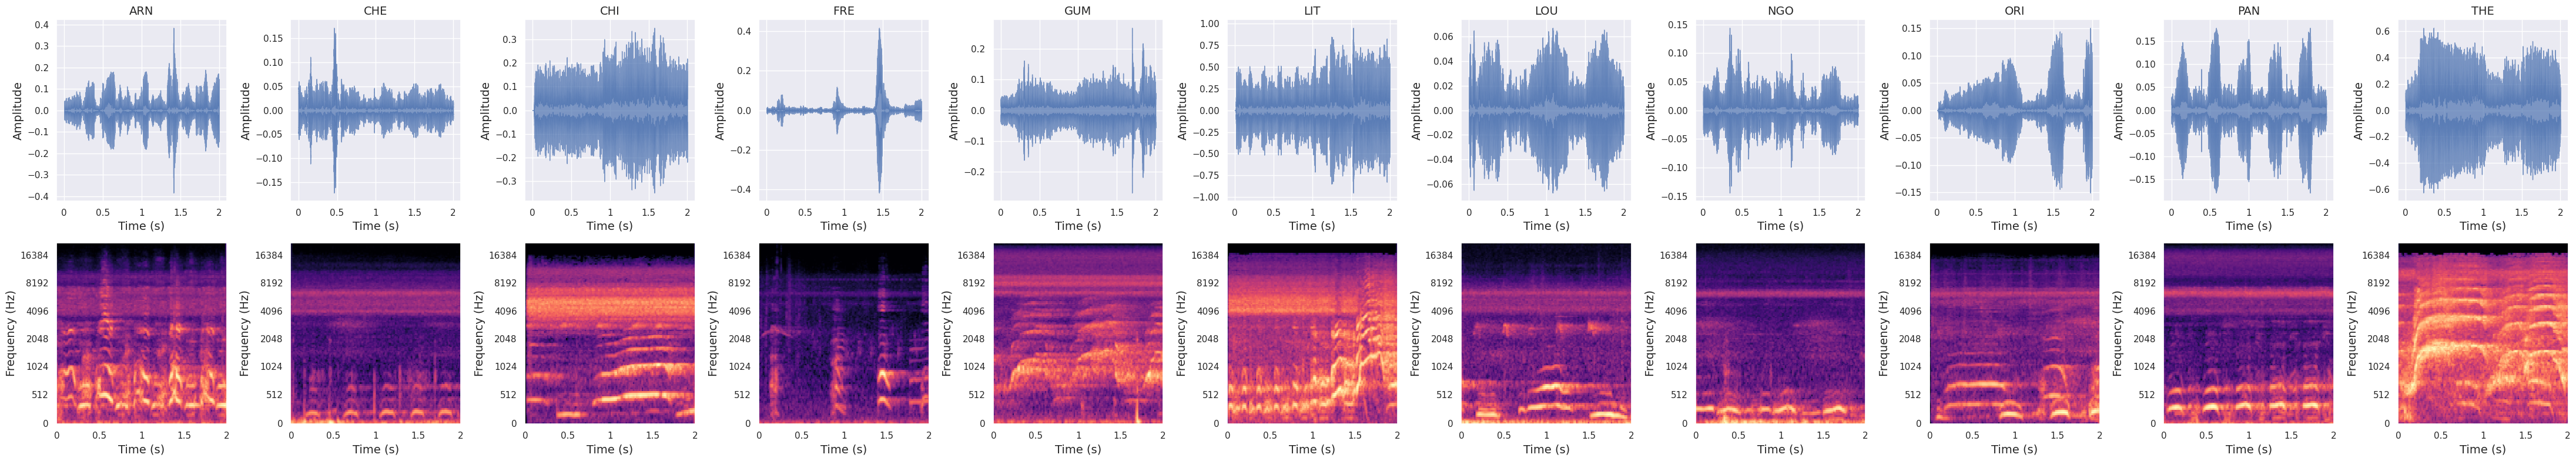

In [8]:
# Create the sample_dict directly from the dataset
sample_dict = {'waveform': [], 'mel_spec': [], 'label': [], 'label_name': []}
seen_labels = set()

for i in range(len(test_dataset)):
    sample, label = test_dataset[i][:2]  # assuming test_dataset[i] returns (sample_dict, label, label_name)
    label_name = test_dataset.classes[label]
    # label_name = test_dataset[i][2]      # if your dataset returns label_name as 3rd element
    if label not in seen_labels:
        waveform = sample['waveform'].numpy()
        mel_spec = sample['data'].squeeze().numpy()
        
        sample_dict['waveform'].append(waveform)
        sample_dict['mel_spec'].append(mel_spec)
        sample_dict['label'].append(label)
        sample_dict['label_name'].append(label_name)
        
        seen_labels.add(label)
    
    # Stop once we've collected all classes
    if len(seen_labels) == len(test_dataset.classes):
        break

print(f"Collected {len(sample_dict['label'])} representative samples")


n_samples = len(sample_dict['label'])

# Create 2 rows (waveform, mel_spec) and n_samples columns
fig, axs = plt.subplots(2, n_samples, figsize=(4*n_samples, 8))

for col in range(n_samples):
    # waveform
    librosa.display.waveshow(sample_dict['waveform'][col], ax=axs[0, col], sr=SAMPLING_RATE, axis='s', alpha=0.7)
    axs[0, col].set_title(f"{sample_dict['label_name'][col]}", fontsize=14)
    # set the xlabel and ylabel
    axs[0, col].set_xlabel("Time (s)", fontsize=14)
    axs[0, col].set_ylabel("Amplitude", fontsize=14)
    
    # mel spectrogram
    S = librosa.feature.melspectrogram(y=sample_dict['waveform'][col].squeeze(), sr=SAMPLING_RATE, n_mels=128,fmax=SAMPLING_RATE//2)
    S_dB = librosa.power_to_db(S, ref=np.max)
    img = librosa.display.specshow(S_dB, x_axis='s',y_axis='mel', sr=SAMPLING_RATE,fmax=SAMPLING_RATE//2, ax=axs[1, col])
    # set the xlabel and ylabel
    axs[1, col].set_xlabel("Time (s)", fontsize=14)
    axs[1, col].set_ylabel("Frequency (Hz)", fontsize=14)

    # img = librosa.display.specshow(sample_dict['mel_spec'][col], x_axis='time',y_axis='mel', sr=val_dataset.sample_rate,fmax=val_dataset.sample_rate//2, ax=axs[1, col])
plt.tight_layout()
# save the figure
plt.savefig(f"results/figures/representative_samples_{DATA_SENTINEL}.png", dpi=300, bbox_inches='tight')
plt.show()

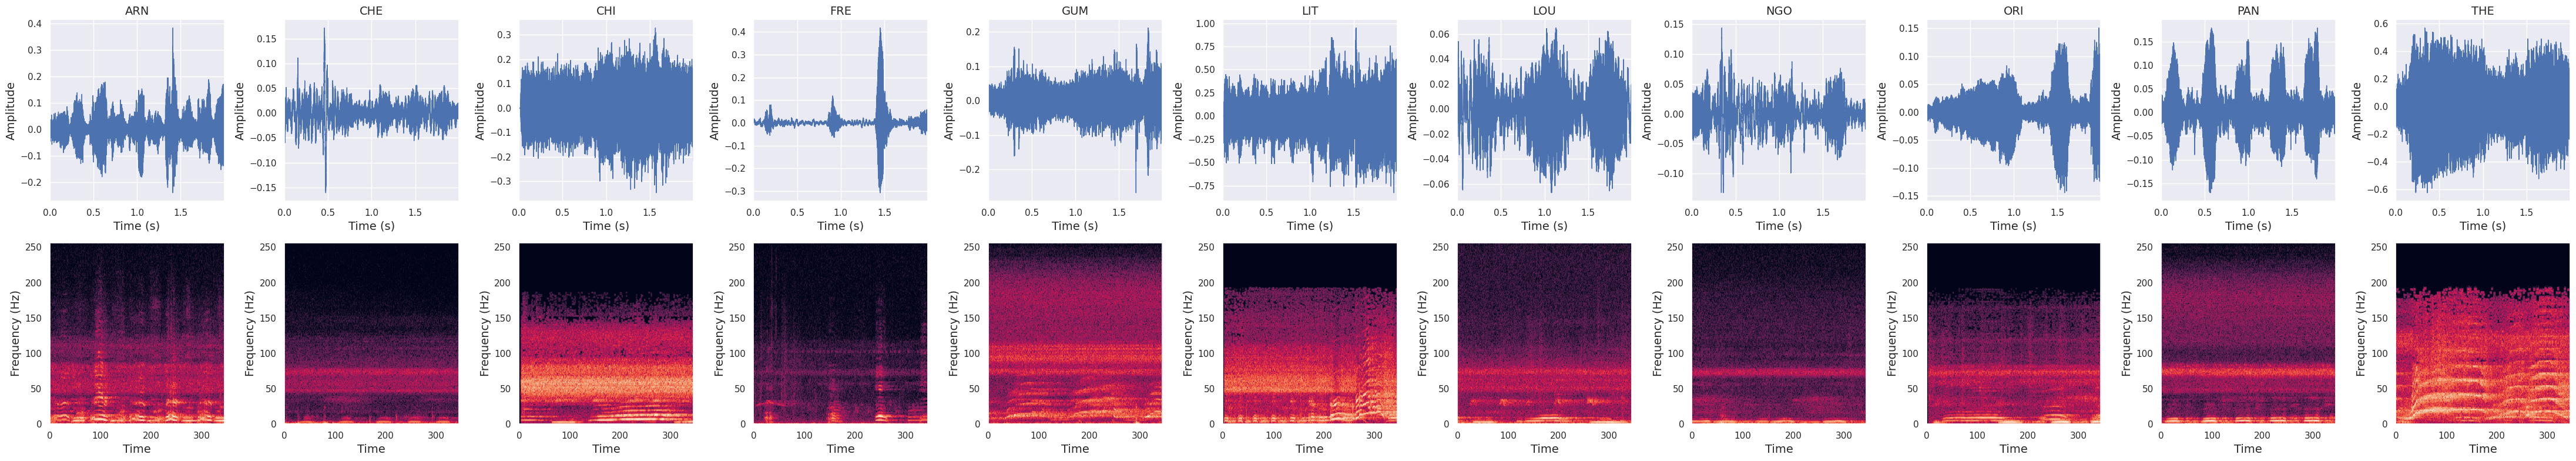

In [9]:
# Create 2 rows (waveform, mel_spec) and n_samples columns
fig, axs = plt.subplots(2, n_samples, figsize=(4*n_samples, 8))
import torch

for col in range(n_samples):
    # waveform

    num_channels, num_frames = sample_dict['waveform'][col].shape
    waveform = torch.tensor(sample_dict['waveform'][col])
    time_axis = torch.arange(0, num_frames) / SAMPLING_RATE

    axs[0, col].plot(time_axis, waveform[0], linewidth=1)
    # set the xlabel and ylabel
    axs[0, col].set_xlabel("Time (s)", fontsize=14)
    axs[0, col].set_ylabel("Amplitude", fontsize=14)
    # axs[0, col].grid(True)
    axs[0, col].set_xlim([0, time_axis[-1]])
    axs[0, col].set_title(f"{sample_dict['label_name'][col]}", fontsize=14)

    axs[0, col].set_title(f"{sample_dict['label_name'][col]}", fontsize=14)
    
    # mel spectrogram

    # ax.set_ylabel(ylabel)
    # Define transform
    import torchaudio.transforms as T
    spectrogram = T.Spectrogram(n_fft=512)

    # Perform transform
    spec = spectrogram(waveform).squeeze().numpy()

    axs[1, col].imshow(librosa.power_to_db(spec), origin="lower", aspect="auto", interpolation="nearest")
    axs[1, col].grid(False)
    # set the xlabel and ylabel
    axs[1, col].set_xlabel("Time", fontsize=14)
    axs[1, col].set_ylabel("Frequency (Hz)", fontsize=14)
plt.tight_layout()
# save the figure
plt.savefig(f"results/figures/representative_samples_v2_{DATA_SENTINEL}.png", dpi=300, bbox_inches='tight')
plt.show()


### Standard Supervised model 

In [10]:
from config import RESULTS_PATH
import pandas as pd
import numpy as np
import os

experiment_start = 200
num_experiments = 20
target_class = "chimp"
model_names = ['CustomCNNModel', 'ViTModel']
modelstrs = ["resnet18", "dense121"]

results = {}

for model_name in model_names:
    for modelstr in modelstrs:
        # map save name
        if model_name == 'CustomCNNModel':
            modelstr_save_name = modelstr
        elif model_name == 'SmallResCNNv5':
            modelstr_save_name = 'SmallResCNNv5'
        elif model_name == 'ViTModel':
            modelstr_save_name = 'ViTModel'
        else:
            raise ValueError(f"Unknown model_name: {model_name}")

        acc_values, f1_values = [], []

        for exp in range(experiment_start, experiment_start + num_experiments):
            file_path = f"{RESULTS_PATH}/test_results_supervised_{modelstr}_{target_class}_{modelstr_save_name}_exp_{exp}.csv"
            if not os.path.exists(file_path):
                continue

            df = pd.read_csv(file_path)

            if all(col in df.columns for col in ["test_acc", "test_f1"]):
                acc = df["test_acc"].mean()
                f1 = df["test_f1"].mean()
                acc_values.append(acc)
                f1_values.append(f1)
            else:
                print(f"⚠️ Skipping {file_path}: Missing required columns")

        if acc_values and f1_values:
            results[f"{modelstr}_{model_name}"] = {
                "acc_mean": np.mean(acc_values),
                "acc_std": np.std(acc_values),
                "f1_mean": np.mean(f1_values),
                "f1_std": np.std(f1_values),
                "n_files": len(acc_values)
            }

# Print summary
print("\n=== Aggregated Results ===")
for k, v in results.items():
    print(f"{k}:")
    print(f"  Accuracy: {v['acc_mean']:.4f} ± {v['acc_std']:.4f}")
    print(f"  F1 Score: {v['f1_mean']:.4f} ± {v['f1_std']:.4f}")
    print(f"  Files processed: {v['n_files']}\n")



=== Aggregated Results ===
resnet18_CustomCNNModel:
  Accuracy: 0.8048 ± 0.0000
  F1 Score: 0.8044 ± 0.0000
  Files processed: 1

dense121_CustomCNNModel:
  Accuracy: 0.6575 ± 0.0000
  F1 Score: 0.6558 ± 0.0000
  Files processed: 1

resnet18_ViTModel:
  Accuracy: 0.3151 ± 0.0000
  F1 Score: 0.2622 ± 0.0000
  Files processed: 1

dense121_ViTModel:
  Accuracy: 0.3493 ± 0.0000
  F1 Score: 0.3025 ± 0.0000
  Files processed: 1



### Traditional ML models

In [11]:
import os
import json
import numpy as np
exp_start = 200                   # starting experiment ID
num_experiments = 20              # total number of experiments

# containers for results
results = {
    "decision_tree": {"accuracy": [], "f1": []},
    "random_forest": {"accuracy": [], "f1": []},
    "xgboost": {"accuracy": [], "f1": []},
}

# iterate over experiment IDs
for experiment in range(exp_start, exp_start + num_experiments):
    summary_path = f"{RESULTS_PATH}/final_classical_results{target_class}_exp_{experiment}.json"
    if not os.path.exists(summary_path):
        # print(f"Missing: {summary_path}")
        continue
    
    with open(summary_path, "r") as f:
        summary_results = json.load(f)

    for model in results.keys():
        if model in summary_results:
            results[model]["accuracy"].append(summary_results[model]["accuracy"])
            results[model]["f1"].append(summary_results[model]["f1"])

# compute mean ± std
print("=== Aggregated Results Across Experiments ===")
for model, metrics in results.items():
    if metrics["accuracy"]:
        acc_mean = np.mean(metrics["accuracy"])
        acc_std = np.std(metrics["accuracy"])
        f1_mean = np.mean(metrics["f1"])
        f1_std = np.std(metrics["f1"])
        print(f"{model.replace('_', ' ').title()}:")
        print(f"  Accuracy: {acc_mean:.4f} ± {acc_std:.4f}")
        print(f"  F1 Score: {f1_mean:.4f} ± {f1_std:.4f}\n")
    else:
        print(f"No data found for {model}.\n")


=== Aggregated Results Across Experiments ===
Decision Tree:
  Accuracy: 0.1986 ± 0.0000
  F1 Score: 0.1910 ± 0.0000

Random Forest:
  Accuracy: 0.3562 ± 0.0000
  F1 Score: 0.3037 ± 0.0000

Xgboost:
  Accuracy: 0.4110 ± 0.0000
  F1 Score: 0.3724 ± 0.0000



### Macaque models

In [11]:
target_class = 'macaque'

experiment_start = 100
num_experiments = 20
model_names = ['CustomCNNModel', 'ViTModel']
modelstrs = ["resnet18", "dense121"]

results = {}

for model_name in model_names:
    for modelstr in modelstrs:
        # map save name
        if model_name == 'CustomCNNModel':
            modelstr_save_name = modelstr
        elif model_name == 'SmallResCNNv5':
            modelstr_save_name = 'SmallResCNNv5'
        elif model_name == 'ViTModel':
            modelstr_save_name = 'ViTModel'
        else:
            raise ValueError(f"Unknown model_name: {model_name}")

        acc_values, f1_values = [], []

        for exp in range(experiment_start, experiment_start + num_experiments):
            file_path = f"{RESULTS_PATH}/test_results_supervised_{modelstr}_{target_class}_{modelstr_save_name}_exp_{exp}.csv"
            # print(file_path)
            if not os.path.exists(file_path):
                continue

            df = pd.read_csv(file_path)

            if all(col in df.columns for col in ["test_acc", "test_f1"]):
                acc = df["test_acc"].mean()
                f1 = df["test_f1"].mean()
                acc_values.append(acc)
                f1_values.append(f1)
            else:
                print(f"⚠️ Skipping {file_path}: Missing required columns")

        if acc_values and f1_values:
            results[f"{modelstr}_{model_name}"] = {
                "acc_mean": np.mean(acc_values),
                "acc_std": np.std(acc_values),
                "f1_mean": np.mean(f1_values),
                "f1_std": np.std(f1_values),
                "n_files": len(acc_values)
            }

# Print summary
print("\n=== Aggregated Results ===")
for k, v in results.items():
    print(f"{k}:")
    print(f"  Accuracy: {v['acc_mean']:.4f} ± {v['acc_std']:.4f}")
    print(f"  F1 Score: {v['f1_mean']:.4f} ± {v['f1_std']:.4f}")
    print(f"  Files processed: {v['n_files']}\n")



=== Aggregated Results ===
resnet18_CustomCNNModel:
  Accuracy: 0.9959 ± 0.0000
  F1 Score: 0.9959 ± 0.0000
  Files processed: 1

dense121_CustomCNNModel:
  Accuracy: 0.9973 ± 0.0000
  F1 Score: 0.9973 ± 0.0000
  Files processed: 1

dense121_ViTModel:
  Accuracy: 0.9918 ± 0.0000
  F1 Score: 0.9918 ± 0.0000
  Files processed: 1



In [12]:

exp_start = 100                   # starting experiment ID
num_experiments = 20              # total number of experiments

# containers for results
results = {
    "decision_tree": {"accuracy": [], "f1": []},
    "random_forest": {"accuracy": [], "f1": []},
    "xgboost": {"accuracy": [], "f1": []},
}

# iterate over experiment IDs
for experiment in range(exp_start, exp_start + num_experiments):
    summary_path = f"{RESULTS_PATH}/final_classical_results{target_class}_exp_{experiment}.json"
    if not os.path.exists(summary_path):
        # print(f"Missing: {summary_path}")
        continue
    
    with open(summary_path, "r") as f:
        summary_results = json.load(f)

    for model in results.keys():
        if model in summary_results:
            results[model]["accuracy"].append(summary_results[model]["accuracy"])
            results[model]["f1"].append(summary_results[model]["f1"])

# compute mean ± std
print("=== Aggregated Results Across Experiments ===")
for model, metrics in results.items():
    if metrics["accuracy"]:
        acc_mean = np.mean(metrics["accuracy"])
        acc_std = np.std(metrics["accuracy"])
        f1_mean = np.mean(metrics["f1"])
        f1_std = np.std(metrics["f1"])
        print(f"{model.replace('_', ' ').title()}:")
        print(f"  Accuracy: {acc_mean:.4f} ± {acc_std:.4f}")
        print(f"  F1 Score: {f1_mean:.4f} ± {f1_std:.4f}\n")
    else:
        print(f"No data found for {model}.\n")


=== Aggregated Results Across Experiments ===
Decision Tree:
  Accuracy: 0.8668 ± 0.0000
  F1 Score: 0.8674 ± 0.0000

Random Forest:
  Accuracy: 0.9511 ± 0.0000
  F1 Score: 0.9509 ± 0.0000

Xgboost:
  Accuracy: 0.9674 ± 0.0000
  F1 Score: 0.9671 ± 0.0000



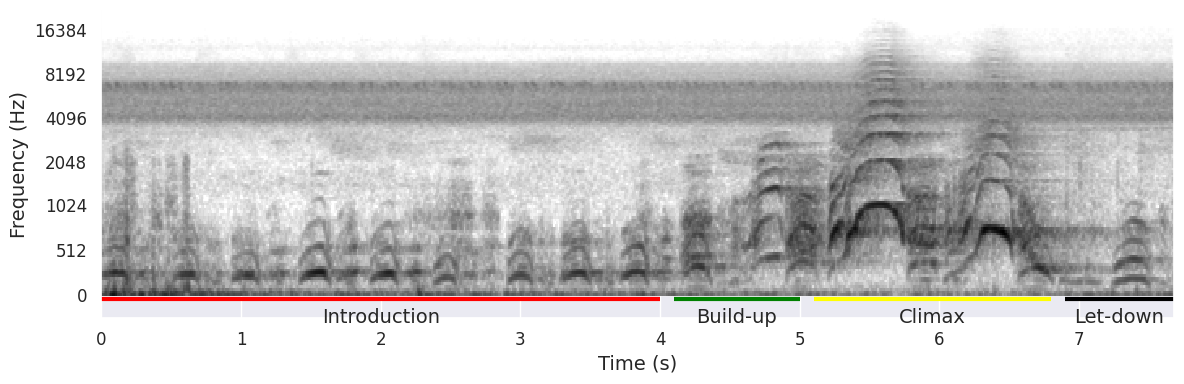

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display

# ----------------------------------------------------
# Load your audio
# ----------------------------------------------------
waveform, sr = librosa.load('samples/loa_LmS_08;00_CHI_ph,dr_rt_tv.wav', sr=None)

# ----------------------------------------------------
# Compute spectrogram using Librosa
# ----------------------------------------------------
n_fft = 1024
hop_length = 512

# STFT
S = librosa.stft(waveform, n_fft=n_fft, hop_length=hop_length)
S_db = librosa.amplitude_to_db(np.abs(S), ref=np.max)

# ----------------------------------------------------
# Plot spectrogram using librosa.display
# ----------------------------------------------------
plt.figure(figsize=(12, 4))
S = librosa.feature.melspectrogram(y=waveform, sr=sr, n_mels=128,fmax=sr//2)
S_dB = librosa.power_to_db(S, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='s',y_axis='mel', sr=sr,fmax=sr//2,cmap='gray_r')
# librosa.display.specshow(S_db, sr=sr, hop_length=hop_length, x_axis='s', y_axis='hz', cmap='gray_r')
# plt.ylim(0, 5000)  # show up to 5 kHz
plt.ylabel("Frequency (Hz)", fontsize=14)
plt.xlabel("Time (s)", fontsize=14)
# xyticks fontsize
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# ----------------------------------------------------
# Annotate pant-hoot phases
# ----------------------------------------------------
intro_start, intro_end = 0.0, 4.0
build_start, build_end = 4.1, 5.0
climax_start, climax_end = 5.1, 6.8
letdown_start, letdown_end = 6.9, len(waveform)/sr

ypos = -50  # slightly below x-axis in Hz

plt.hlines(y=ypos, xmin=intro_start, xmax=intro_end, color='red', linewidth=3)
plt.text((intro_start + intro_end)/2, ypos - 100, "Introduction", ha='center', va='top', fontsize=14)

plt.hlines(y=ypos, xmin=build_start, xmax=build_end, color='green', linewidth=3)
plt.text((build_start + build_end)/2, ypos - 100, "Build-up", ha='center', va='top', fontsize=14)

plt.hlines(y=ypos, xmin=climax_start, xmax=climax_end, color='yellow', linewidth=3)
plt.text((climax_start + climax_end)/2, ypos - 100, "Climax", ha='center', va='top', fontsize=14)

plt.hlines(y=ypos, xmin=letdown_start, xmax=letdown_end, color='black', linewidth=3)
plt.text((letdown_start + letdown_end)/2, ypos - 100, "Let-down", ha='center', va='top', fontsize=14)

plt.tight_layout()
# save the figure
plt.savefig(f"results/figures/pant_hoot_phases_{DATA_SENTINEL}.png", dpi=300, bbox_inches='tight')
plt.show()
